In [186]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [187]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [188]:
normalize = transforms.Normalize(mean=[0.4563, 0.4076, 0.3895], std=[0.2298, 0.2144, 0.2259])

# lisa_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize((224, 224)),transforms.ToTensor(),normalize])
lisa_transforms = transforms.Compose([ transforms.ToPILImage(),transforms.ToTensor(),normalize])

In [189]:
class_names = ['stop','speedlimit', 'pedestrianCrossing', 'turnLeft','slow', 'signalAhead', 'laneEnds', 'school', 'merge','yield', 'noRightTurn','noLeftTurn', 'roundabout', 'turnRight']
import torch
from torch.utils.data import Dataset

class SubsetLISA(Dataset):
    """
    A custom dataset for the LISA subset, created using filtered image and label tensors.
    """
    def __init__(self, image_tensor_path, label_tensor_path,train:bool, transform=None):
        """
        Args:
            image_tensor_path (str): Path to the images tensor file.
            label_tensor_path (str): Path to the labels tensor file.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.images = torch.load(image_tensor_path)
        self.labels = torch.load(label_tensor_path)
        self.transform = transform
        self.train = train
        self._train_test_split()

        assert len(self.images) == len(self.labels), "Images and labels length mismatch"

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is the input tensor and label is the target tensor.
        """
        image = self.images[index]
        target = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, target

    def _train_test_split(self, test_percent: float = 0.16):
        classes = {}
        for i, cl in enumerate(self.labels.numpy()):
            arr = classes.get(cl, [])
            arr.append(i)
            classes[cl] = arr

        train, test = [], []
        for cl, arr in classes.items():
            split_index = int(len(arr) * test_percent)
            test = test + arr[:split_index]
            train = train + arr[split_index:]

        sub = train if self.train else test
        self.images, self.labels = self.images[sub], self.labels[sub]


In [190]:
# Paths to the saved subset tensors
image_tensor_path = "datasets/lisa-batches/subset_images.tensor"  # Replace with your actual file path
label_tensor_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with your actual file path

# Initialize the dataset
train_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=True, transform = lisa_transforms)
test_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=False, transform = lisa_transforms)

In [191]:
epochs = 100
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,) # num_workers=4,
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [192]:
%run models.ipynb
%run utils.ipynb
%run metrics.ipynb

# Normal Training

In [194]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_normal_subset.pth"
model_save_path = model_path / model_name
model = vgg16().to(device)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [195]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Normal is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Normal is: 97.07%


In [196]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

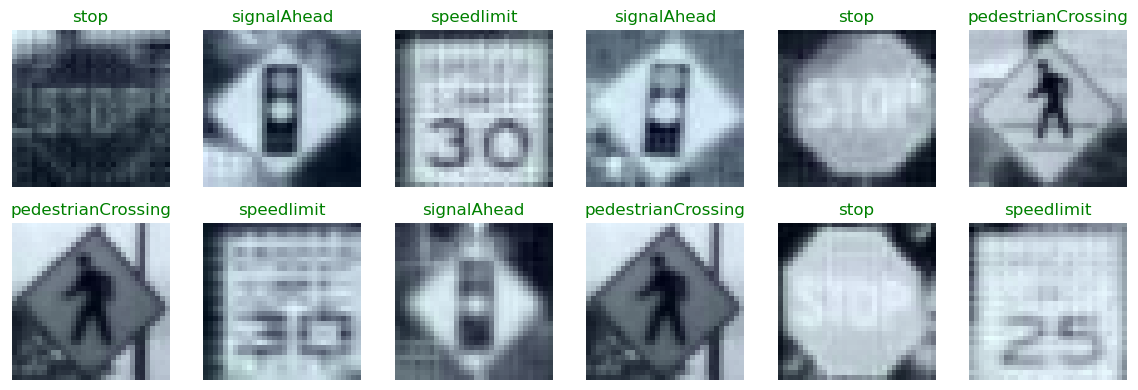

In [210]:
import matplotlib.pyplot as plt
import torch

fig = plt.figure(figsize=(12, 4))
indexes = []
rows, cols = 2, 6

for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    
    # Get the predicted label
    label_pred = torch.argmax(model(img_temp))

    # Add the subplot
    fig.add_subplot(rows, cols, i)
    
    # Permute the image tensor from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0).cpu().numpy()  # Ensure the image is on CPU for matplotlib
    
    # Normalize the image to [0, 1] for proper visualization (if needed)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    
    # Display the image
    plt.imshow(img)  # No cmap='gray' for color images
    
    # Set the title color based on prediction correctness
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g')  # Correct prediction
    else:
        plt.title(class_names[label_pred], color='r')  # Incorrect prediction
    
    plt.axis(False)
    plt.tight_layout()

plt.show()

In [212]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [214]:
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

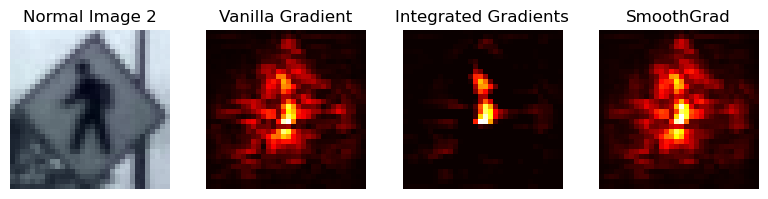

In [215]:
index = indexes[6]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_normal')

# Adversarial Training

In [219]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_adv.pth"
model_save_path = model_path / model_name
model_adv = vgg16().to(device)
model_adv.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [221]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Adversarial is: 97.51%


In [222]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [223]:
# Applying explanation methods on the model outputs
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

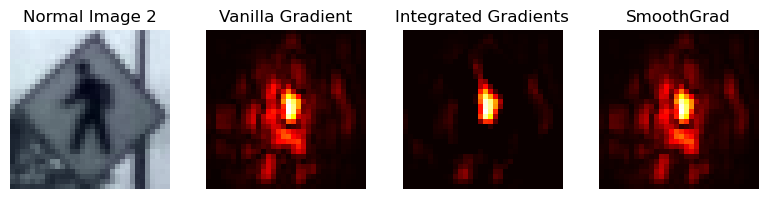

In [225]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_adv, a_batch_integrad_adv, a_batch_smoothgrad_adv, 'lisa_adversarial')

# L1 Pre Prune

In [230]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_pre.pth"
model_save_path = model_path / model_name
model_l1_unstructured = vgg16().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [231]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned L1 UnStructure Pre is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned L1 UnStructure Pre is: 94.47%


In [233]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [234]:
# Applying explanation methods on the model outputs
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

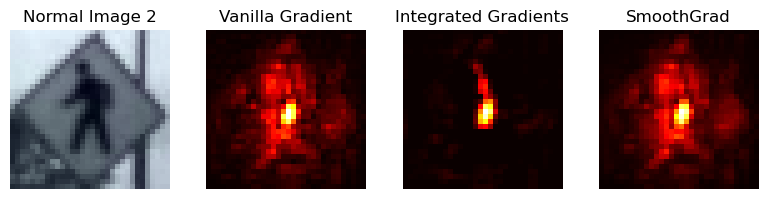

In [235]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_l1, a_batch_integrad_l1, a_batch_smoothgrad_l1, 'lisa_l1_pre')

# Post No Tune L1

In [241]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_l1 = vgg16().to(device)

for name, module in model_no_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_no_tuned_l1):.2f}%")
model_no_tuned_l1.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [243]:
# Model to GPU and eval mode.
model_no_tuned_l1.to(device)
model_no_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_l1, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG-16 Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for VGG-16 Post no tune is: 94.79%


In [244]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [245]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

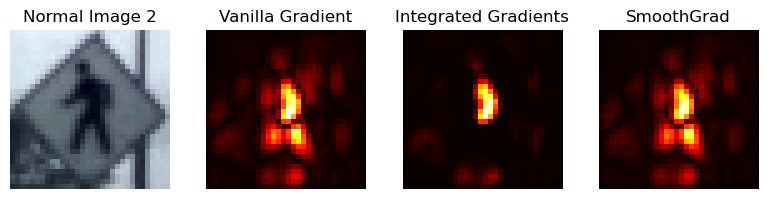

In [247]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_l1_post_no_tuned')

# Post Tuned l1

In [252]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_l1 = vgg16().to(device)

for name, module in model_post_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_post_tuned_l1):.2f}%")
model_post_tuned_l1.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [253]:
# Model to GPU and eval mode.
model_post_tuned_l1.to(device)
model_post_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_l1, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 95.34%


In [255]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [256]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

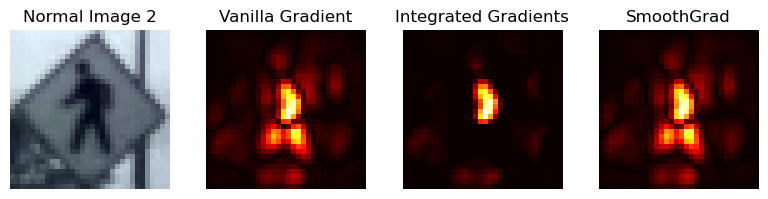

In [257]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_l1_post_tuned')

# Global Pre Prune

In [263]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_pre.pth"
model_save_path = model_path / model_name
model_global = vgg16().to(device)

parameters_to_prune = (
    (model_global.features[0], 'weight'),
    (model_global.features[2], 'weight'),
    (model_global.features[5], 'weight'),
    (model_global.features[7], 'weight'),
    (model_global.features[10], 'weight'),
    (model_global.features[12], 'weight'),
    (model_global.features[14], 'weight'),
    (model_global.features[17], 'weight'),
    (model_global.features[19], 'weight'),
    (model_global.features[21], 'weight'),
    (model_global.features[24], 'weight'),
    (model_global.features[26], 'weight'),
    (model_global.features[28], 'weight'),
    (model_global.classifier[1], 'weight'),
    (model_global.classifier[4], 'weight'),
    (model_global.classifier[6], 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"VGG global sparsity = {compute_sparsity_vgg(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
VGG global sparsity = 20.00%


<All keys matched successfully>

In [264]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Global Pre is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Global Pre is: 93.93%


In [265]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [266]:
# Applying explanation methods on the model outputs
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

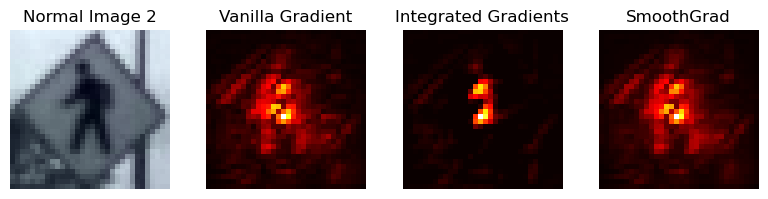

In [268]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_global, a_batch_integrad_global, a_batch_smoothgrad_global, 'lisa_global_pre')

# Global Post Prune No tune

In [274]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_global = vgg16().to(device)

parameters_to_prune = (
    (model_no_tuned_global.features[0], 'weight'),
    (model_no_tuned_global.features[2], 'weight'),
    (model_no_tuned_global.features[5], 'weight'),
    (model_no_tuned_global.features[7], 'weight'),
    (model_no_tuned_global.features[10], 'weight'),
    (model_no_tuned_global.features[12], 'weight'),
    (model_no_tuned_global.features[14], 'weight'),
    (model_no_tuned_global.features[17], 'weight'),
    (model_no_tuned_global.features[19], 'weight'),
    (model_no_tuned_global.features[21], 'weight'),
    (model_no_tuned_global.features[24], 'weight'),
    (model_no_tuned_global.features[26], 'weight'),
    (model_no_tuned_global.features[28], 'weight'),
    (model_no_tuned_global.classifier[1], 'weight'),
    (model_no_tuned_global.classifier[4], 'weight'),
    (model_no_tuned_global.classifier[6], 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_vgg(model_no_tuned_global):.2f}%")

model_no_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [275]:
# Model to GPU and eval mode.
model_no_tuned_global.to(device)
model_no_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Post no tune is: 94.69%


In [276]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [277]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

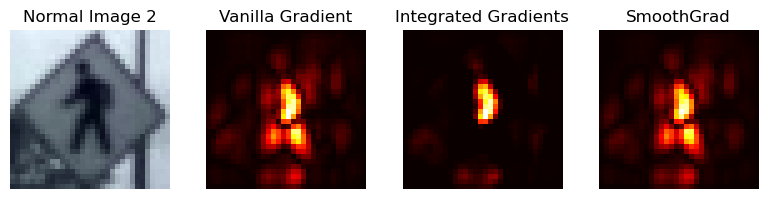

In [279]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_global_no_tune')

# Tuned Global

In [285]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_global = vgg16().to(device)

parameters_to_prune = (
    (model_post_tuned_global.features[0], 'weight'),
    (model_post_tuned_global.features[2], 'weight'),
    (model_post_tuned_global.features[5], 'weight'),
    (model_post_tuned_global.features[7], 'weight'),
    (model_post_tuned_global.features[10], 'weight'),
    (model_post_tuned_global.features[12], 'weight'),
    (model_post_tuned_global.features[14], 'weight'),
    (model_post_tuned_global.features[17], 'weight'),
    (model_post_tuned_global.features[19], 'weight'),
    (model_post_tuned_global.features[21], 'weight'),
    (model_post_tuned_global.features[24], 'weight'),
    (model_post_tuned_global.features[26], 'weight'),
    (model_post_tuned_global.features[28], 'weight'),
    (model_post_tuned_global.classifier[1], 'weight'),
    (model_post_tuned_global.classifier[4], 'weight'),
    (model_post_tuned_global.classifier[6], 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_vgg(model_post_tuned_global):.2f}%")

model_post_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [286]:
# Model to GPU and eval mode.
model_post_tuned_global.to(device)
model_post_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Global post tuned is: {(100 * test_acc):.2f}%")

Test accuracy for Global post tuned is: 95.44%


In [287]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [288]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

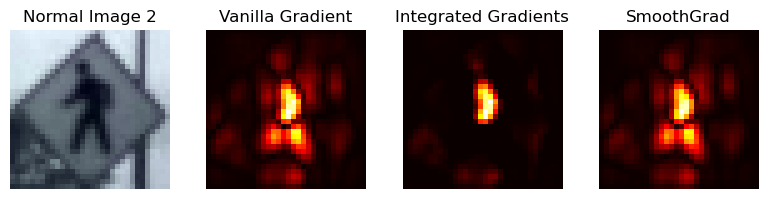

In [290]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_global_post_tuned')

# Layered Pre

In [296]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_pre.pth"
model_save_path = model_path / model_name
model_structured = vgg16().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(model_save_path))


VGG global sparsity = 9.98%


<All keys matched successfully>

In [297]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Pre Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Pre Layered Structure is: 91.32%


In [298]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [300]:
# Applying explanation methods on the model outputs
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

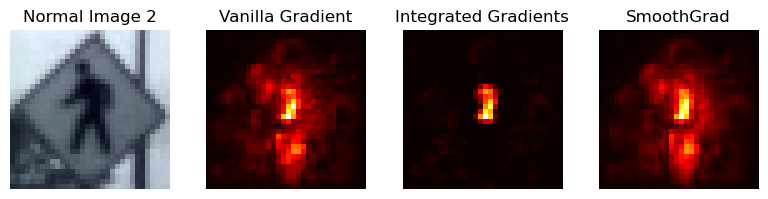

In [301]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_structured, a_batch_integrad_structured, a_batch_smoothgrad_structured, 'lisa_layered_pre')

# Layered Post No Tune

In [307]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_layered = vgg16().to(device)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_no_tuned_layered.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_no_tuned_layered):.2f}%")

model_no_tuned_layered.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 9.98%


<All keys matched successfully>

In [308]:
# Model to GPU and eval mode.
model_no_tuned_layered.to(device)
model_no_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG POST Layeredis: {(100 * test_acc):.2f}%")

Test accuracy for VGG POST Layeredis: 93.82%


In [309]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [311]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

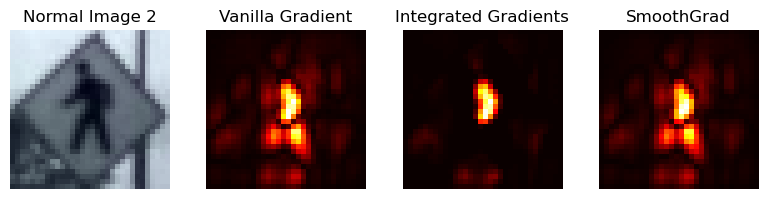

In [312]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_layered_no_tune')

# Layered Tuned

In [318]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_layered = vgg16().to(device)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_post_tuned_layered.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_post_tuned_layered):.2f}%")

model_post_tuned_layered.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 9.98%


<All keys matched successfully>

In [319]:
# Model to GPU and eval mode.
model_post_tuned_layered.to(device)
model_post_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Layered Tuned is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Layered Tuned is: 94.90%


In [321]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [322]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

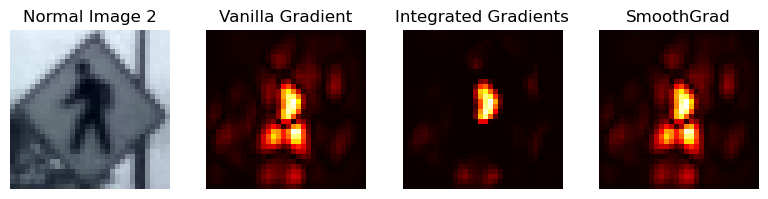

In [323]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_layered_post_tuned')

In [ ]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [ ]:
xai_method=["SmoothGrad"]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# ROAD VANILLA GRADIENT

In [18]:
result_normal = {1: np.float64(0.9774555255961048), 11: np.float64(0.724290535782767), 21: np.float64(0.6685124645246117), 31: np.float64(0.5918968391718802), 41: np.float64(0.527470325861938), 51: np.float64(0.4627370852287785), 61: np.float64(0.38643117847061426), 71: np.float64(0.3292417536692573), 81: np.float64(0.2637233764458619), 91: np.float64(0.18294665963716308)}

result_adv = {1: np.float64(0.98982720914864), 11: np.float64(0.749409518415537), 21: np.float64(0.6514241516970902), 31: np.float64(0.6007111901875493), 41: np.float64(0.5519832120862617), 51: np.float64(0.4700744808041527), 61: np.float64(0.40718721965822796), 71: np.float64(0.3794932586781008), 81: np.float64(0.346972015749056), 91: np.float64(0.3118517899169843)}

result_l1_pre = {1: np.float64(0.9766117145237474), 11: np.float64(0.7437198382854184), 21: np.float64(0.6197042074920223), 31: np.float64(0.5310855217143715), 41: np.float64(0.45194580518565397), 51: np.float64(0.401369914452634), 61: np.float64(0.33131157208030204), 71: np.float64(0.28773197262347017), 81: np.float64(0.24031850001598448), 91: np.float64(0.1902704681742908)}

result_no_tuned_l1 ={1: np.float64(0.9779619358737178), 11: np.float64(0.723411195810308), 21: np.float64(0.6670083318418831), 31: np.float64(0.5954204371757945), 41: np.float64(0.5226482822791914), 51: np.float64(0.45062160894624853), 61: np.float64(0.3850722406900511), 71: np.float64(0.31825179734040654), 81: np.float64(0.2566221057452566), 91: np.float64(0.19321844450594108)}

result_post_tuned_l1 ={1: np.float64(0.9683225307021417), 11: np.float64(0.7176940299951948), 21: np.float64(0.6610278089518113), 31: np.float64(0.5939195598721511), 41: np.float64(0.5074141612327172), 51: np.float64(0.4085529362045139), 61: np.float64(0.3567613057662939), 71: np.float64(0.3143575991908619), 81: np.float64(0.26582937427167663), 91: np.float64(0.2030372812113763)}

result_global_pre ={1: np.float64(0.9865913803969938), 11: np.float64(0.7626119396119313), 21: np.float64(0.5436780590169127), 31: np.float64(0.4615570488527658), 41: np.float64(0.4259862417794644), 51: np.float64(0.36980566247074376), 61: np.float64(0.3346831720177361), 71: np.float64(0.3066670538044576), 81: np.float64(0.2888029558395696), 91: np.float64(0.25818029333251824)}

result_no_tuned_global={1: np.float64(0.9843065643108685), 11: np.float64(0.7232079422292775), 21: np.float64(0.6551019623039119), 31: np.float64(0.6041982611027915), 41: np.float64(0.537761023694448), 51: np.float64(0.45956293336323945), 61: np.float64(0.3848744188097386), 71: np.float64(0.32920009846403286), 81: np.float64(0.2694923850650135), 91: np.float64(0.1869418539271245)}

result_post_tuned_global={1: np.float64(0.9796345012894729), 11: np.float64(0.7257161225786117), 21: np.float64(0.6515529790897406), 31: np.float64(0.5707647764650411), 41: np.float64(0.4921510288013041), 51: np.float64(0.432762674648651), 61: np.float64(0.36762828717649254), 71: np.float64(0.32343842701564113), 81: np.float64(0.28930828992714747), 91: np.float64(0.2040736342198184)}

result_pre_tuned_layered={1: np.float64(0.9816416386865376), 11: np.float64(0.7018077444895309), 21: np.float64(0.5754899032012154), 31: np.float64(0.506824873031329), 41: np.float64(0.4407194437647442), 51: np.float64(0.3934518789741554), 61: np.float64(0.3765081158197691), 71: np.float64(0.34766435687283087), 81: np.float64(0.32952992218283395), 91: np.float64(0.2965470676512657)}

result_post_no_tuned_layered={1: np.float64(0.9712388143939074), 11: np.float64(0.8073267292058266), 21: np.float64(0.7581851455712862), 31: np.float64(0.6839487339174163), 41: np.float64(0.6002064392557492), 51: np.float64(0.5322922933321405), 61: np.float64(0.46719593213512844), 71: np.float64(0.41025227869755393), 81: np.float64(0.31426609928289984), 91: np.float64(0.23666452984801367)}

result_post_tuned_layered={1: np.float64(0.9781294176999894), 11: np.float64(0.8073371965609938), 21: np.float64(0.7432505720858295), 31: np.float64(0.6820224272279632), 41: np.float64(0.5821819620307914), 51: np.float64(0.5147455226768844), 61: np.float64(0.454529734179933), 71: np.float64(0.3773411485898129), 81: np.float64(0.3181161834114148), 91: np.float64(0.22629064988427577)}


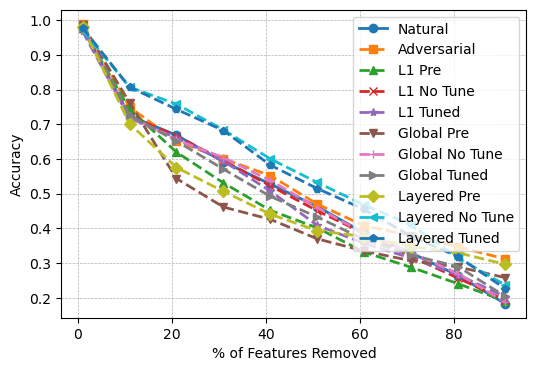

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA_VANILLA_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD INTEGRATED GRADIENT

In [22]:
result_normal = {1: np.float64(0.9713531020211177), 11: np.float64(0.6477443896386162), 21: np.float64(0.5471635958254034), 31: np.float64(0.4619919218203265), 41: np.float64(0.38495851983243123), 51: np.float64(0.3543964730609261), 61: np.float64(0.35234286125441716), 71: np.float64(0.3590602064718807), 81: np.float64(0.3728652791725771), 91: np.float64(0.374918818303583)}

result_adv = {1: np.float64(0.9928329461866048), 11: np.float64(0.8068901580432856), 21: np.float64(0.689969473168234), 31: np.float64(0.5904024608794475), 41: np.float64(0.5071289479599865), 51: np.float64(0.45631980349181367), 61: np.float64(0.4175012020281493), 71: np.float64(0.3678975356861863), 81: np.float64(0.31603834938118963), 91: np.float64(0.25510057229028515)}

result_l1_pre = {1: np.float64(0.977575948840637), 11: np.float64(0.7211426458984618), 21: np.float64(0.5973975473341098), 31: np.float64(0.5276289469809565), 41: np.float64(0.46396439423411195), 51: np.float64(0.4258189485336899), 61: np.float64(0.4139335336478711), 71: np.float64(0.42911538215426603), 81: np.float64(0.4300615688329983), 91: np.float64(0.3963289729200547)}

result_no_tuned_l1 ={1: np.float64(0.9761706348589708), 11: np.float64(0.6499955650591956), 21: np.float64(0.5452148220302001), 31: np.float64(0.4567463717995275), 41: np.float64(0.3803918106075771), 51: np.float64(0.34669067326189357), 61: np.float64(0.34204875567936155), 71: np.float64(0.3488866920673658), 81: np.float64(0.3655141543664755), 91: np.float64(0.3537464832083806)}

result_post_tuned_l1 ={1: np.float64(0.9624291908959405), 11: np.float64(0.6398706061097499), 21: np.float64(0.5377640092342476), 31: np.float64(0.46773779675677296), 41: np.float64(0.3945964475018419), 51: np.float64(0.33467799991078495), 61: np.float64(0.32844603209932777), 71: np.float64(0.3623330831467225), 81: np.float64(0.38653424197617947), 91: np.float64(0.37285018180874074)}

result_global_pre ={1: np.float64(0.9886501649048557), 11: np.float64(0.8124449615762129), 21: np.float64(0.6776559315941467), 31: np.float64(0.5549118118533728), 41: np.float64(0.46753067408338145), 51: np.float64(0.4170317608290657), 61: np.float64(0.3888516058339885), 71: np.float64(0.3948141757799004), 81: np.float64(0.3584776702722063), 91: np.float64(0.30776325080875727)}

result_no_tuned_global={1: np.float64(0.9744189101828926), 11: np.float64(0.652139692565372), 21: np.float64(0.5472737475151005), 31: np.float64(0.4619402037219334), 41: np.float64(0.3776210195813264), 51: np.float64(0.3481665292803986), 61: np.float64(0.3469212478018197), 71: np.float64(0.3523123888963223), 81: np.float64(0.3711587301208044), 91: np.float64(0.36732547981656344)}

result_post_tuned_global={1: np.float64(0.9675558654254344), 11: np.float64(0.6696943074109176), 21: np.float64(0.5291736718035472), 31: np.float64(0.4202615284721332), 41: np.float64(0.34633826251547023), 51: np.float64(0.3122364598881669), 61: np.float64(0.29238001294043936), 71: np.float64(0.31151423677869916), 81: np.float64(0.3435508776521674), 91: np.float64(0.3230104331657201)}

result_pre_tuned_layered={1: np.float64(0.9839446683633255), 11: np.float64(0.7746804687622304), 21: np.float64(0.6879283210003689), 31: np.float64(0.6393644598046816), 41: np.float64(0.5913856591016176), 51: np.float64(0.5406733793403462), 61: np.float64(0.5269318006123911), 71: np.float64(0.4817699535770109), 81: np.float64(0.44014121999473793), 91: np.float64(0.38450114219859727)}

result_post_no_tuned_layered={1: np.float64(0.9697964411191918), 11: np.float64(0.7755751986595119), 21: np.float64(0.6530969002333182), 31: np.float64(0.5340284730802112), 41: np.float64(0.45934395139328815), 51: np.float64(0.4184244862319845), 61: np.float64(0.4133151832485457), 71: np.float64(0.42207092345312697), 81: np.float64(0.43595701612405285), 91: np.float64(0.41488216001193706)}

result_post_tuned_layered={1: np.float64(0.9815074097479652), 11: np.float64(0.7245418164339997), 21: np.float64(0.6142720764498049), 31: np.float64(0.5301586850038431), 41: np.float64(0.4540202183916087), 51: np.float64(0.40498495768382664), 61: np.float64(0.4060569743573832), 71: np.float64(0.4332193049123909), 81: np.float64(0.45092136154829754), 91: np.float64(0.477725465388855)}


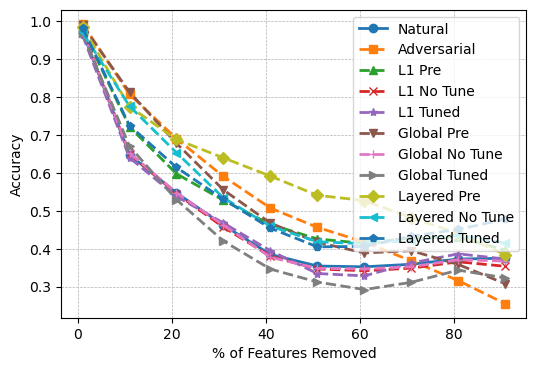

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA__IG_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD SMOOTHGRAD

In [26]:
result_normal = {1: np.float64(0.9751548527754526), 11: np.float64(0.7887387324378351), 21: np.float64(0.7175890041690316), 31: np.float64(0.6556503053616749), 41: np.float64(0.593692528505553), 51: np.float64(0.499068476544198), 61: np.float64(0.43931455026646843), 71: np.float64(0.362094288602161), 81: np.float64(0.29814650215527094), 91: np.float64(0.19716642690934294)}

result_adv = {1: np.float64(0.99286105450293), 11: np.float64(0.751105988539241), 21: np.float64(0.6604149076514969), 31: np.float64(0.5949199207827208), 41: np.float64(0.5274335261759647), 51: np.float64(0.46547221682046785), 61: np.float64(0.4106006790832054), 71: np.float64(0.39362629637971114), 81: np.float64(0.33907794409118075), 91: np.float64(0.2903293603981071)}

result_l1_pre = {1: np.float64(0.9813267665825307), 11: np.float64(0.7767173548981277), 21: np.float64(0.6767783458317227), 31: np.float64(0.5668887333885528), 41: np.float64(0.47071454439877203), 51: np.float64(0.41085590674746547), 61: np.float64(0.3616084426137939), 71: np.float64(0.3078926598039706), 81: np.float64(0.26198057398758423), 91: np.float64(0.23836842926253024)}

result_no_tuned_l1 ={1: np.float64(0.9777982416687652), 11: np.float64(0.7934367484537275), 21: np.float64(0.7425296957422274), 31: np.float64(0.6693161094435979), 41: np.float64(0.5855218295849932), 51: np.float64(0.4917067002992744), 61: np.float64(0.42045442648721376), 71: np.float64(0.34564923200029884), 81: np.float64(0.26920507591063436), 91: np.float64(0.17161532519373485)}

result_post_tuned_l1 ={1: np.float64(0.9731954111126255), 11: np.float64(0.7861961220817253), 21: np.float64(0.739199829391564), 31: np.float64(0.6575462306030595), 41: np.float64(0.552631734894476), 51: np.float64(0.44059483333663013), 61: np.float64(0.37848510800625706), 71: np.float64(0.33830861935794426), 81: np.float64(0.24896904954001936), 91: np.float64(0.1957545957277978)}

result_global_pre ={1: np.float64(0.9904194942975337), 11: np.float64(0.7515945381107527), 21: np.float64(0.5770643772177565), 31: np.float64(0.4969339426792453), 41: np.float64(0.45222625695286844), 51: np.float64(0.4102855670735273), 61: np.float64(0.34661811039478024), 71: np.float64(0.31991036350544527), 81: np.float64(0.27286945900898163), 91: np.float64(0.20272405524957887)}

result_no_tuned_global={1: np.float64(0.9802882544757118), 11: np.float64(0.784894640768081), 21: np.float64(0.728765958825894), 31: np.float64(0.6670183701310012), 41: np.float64(0.5840970729025544), 51: np.float64(0.4980068760323144), 61: np.float64(0.4245023947089225), 71: np.float64(0.34470013269830574), 81: np.float64(0.27774768492854435), 91: np.float64(0.17154349062128182)}

result_post_tuned_global={1: np.float64(0.9886686991869919), 11: np.float64(0.8102317073170732), 21: np.float64(0.7334339430894309), 31: np.float64(0.6522723577235773), 41: np.float64(0.55444918699187), 51: np.float64(0.4541392276422764), 61: np.float64(0.41088109756097557), 71: np.float64(0.34299999999999997), 81: np.float64(0.26565853658536587), 91: np.float64(0.17374186991869917)}

result_pre_tuned_layered={1: np.float64(0.9794524491583346), 11: np.float64(0.6735193303265182), 21: np.float64(0.5265184644352526), 31: np.float64(0.4632830629223908), 41: np.float64(0.3984846407975439), 51: np.float64(0.36929217713706625), 61: np.float64(0.35218847752012117), 71: np.float64(0.32837185010018444), 81: np.float64(0.31878191804078854), 91: np.float64(0.28447179023005437)}

result_post_no_tuned_layered={1: np.float64(0.9715587531864706), 11: np.float64(0.8119662204040256), 21: np.float64(0.7515381206759554), 31: np.float64(0.6670986397500799), 41: np.float64(0.5664767518027256), 51: np.float64(0.4676278706538484), 61: np.float64(0.4152883517157118), 71: np.float64(0.3361966775078317), 81: np.float64(0.2787165052855415), 91: np.float64(0.19051314345532316)}

result_post_tuned_layered={1: np.float64(0.9751801819962539), 11: np.float64(0.7941597432956589), 21: np.float64(0.730901703907845), 31: np.float64(0.6531158437963343), 41: np.float64(0.5645536524900687), 51: np.float64(0.4841666737165782), 61: np.float64(0.41426806489467677), 71: np.float64(0.33600631158518035), 81: np.float64(0.2727591770038179), 91: np.float64(0.20335923955243068)}


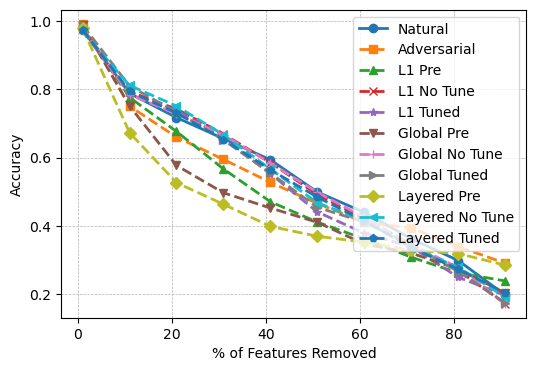

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA__SMOOTH_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# INPUT STABILITY

In [43]:
normal_input_saliency =-0.5071052508248292
normal_input_ig =1.2867332764726414
normal_input_smooth =-0.754249886322607

adversarial_input_saliency = -0.44934980925188295
adversarial_input_ig =2.20081581032886
adversarial_input_smooth =-0.7625224737317099

l1_pre_input_saliency =-0.3967743239518707
l1_pre_input_ig =1.5261503943253714
l1_pre_input_smooth =-0.8131973566211894

l1_post_no_tune_input_saliency = -0.5263451866915042
l1_post_no_tune_input_ig = 1.109350192314788
l1_post_no_tune_input_smooth =-0.8141687264598251

l1_post_tune_input_saliency = -0.47048612412095797
l1_post_tune_input_ig = 1.0585235579946617
l1_post_tune_input_smooth = -0.8014092775039529

global_pre_input_saliency =-0.5768975304583858
global_pre_input_ig =1.6432836180902437
global_pre_input_smooth = -0.8738825903444909

global_no_tune_input_saliency =-0.5145838115965163
global_no_tune_input_ig = 1.5466620289780708
global_no_tune_input_smooth = -0.8044404901688171

global_tune_input_saliency = -0.4495360326574697
global_tune_input_ig =1.188461414078262
global_tune_input_smooth = -0.8071260460931775

layered_pre_input_saliency =-0.6378901169100571
layered_pre_tune_input_ig = 1.1312891677390498
layered_pre_tune_input_smooth = -0.9682680240737083

layered_no_tune_input_saliency =-0.4899455369129962
layered_no_tune_input_ig = 1.4093450563739898
layered_no_tune_input_smooth = -0.7506420748141539

layered_tune_input_saliency = -0.4420053716176202
layered_tune_input_ig =  1.6102759603432926
layered_tune_input_smooth =-0.7825366657356266

In [45]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_pre_input_saliency, l1_post_no_tune_input_saliency, l1_post_tune_input_saliency,global_pre_input_saliency, global_no_tune_input_saliency,global_tune_input_saliency, layered_pre_input_saliency,layered_no_tune_input_saliency, layered_tune_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_pre_input_ig, l1_post_no_tune_input_ig, l1_post_tune_input_ig,global_pre_input_ig,global_no_tune_input_ig,global_tune_input_ig, layered_pre_tune_input_ig, layered_no_tune_input_ig, layered_tune_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_pre_input_smooth, l1_post_no_tune_input_smooth, l1_post_tune_input_smooth, global_pre_input_smooth, global_no_tune_input_smooth, global_tune_input_smooth, layered_pre_tune_input_smooth, layered_no_tune_input_smooth, layered_tune_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,-0.507105,1.286733,-0.754250
Adversarial Model,-0.449350,2.200816,-0.762522
L1 Pre Prune,-0.396774,1.526150,-0.813197
L1 No Tune Prune,-0.526345,1.109350,-0.814169
L1 Tuned Prune,-0.470486,1.058524,-0.801409
Global Pre Prune,-0.576898,1.643284,-0.873883
Global No Tune Prune,-0.514584,1.546662,-0.804440
Global Tuned Prune,-0.449536,1.188461,-0.807126
Layered Pre Prune,-0.637890,1.131289,-0.968268
Layered No Tune Prune,-0.489946,1.409345,-0.750642


# OUTPUT STABILITY

In [47]:
normal_output_saliency =0.8944237420001964
normal_output_ig = 2.7891634248417296
normal_output_smooth = 0.6394694892274415

adversarial_output_saliency = 1.7947530298995313
adversarial_output_ig =3.7769726334562717
adversarial_output_smooth = 1.3995877702810793

l1_pre_output_saliency = 1.23858601030218
l1_pre_output_ig = 3.465408051787847
l1_pre_output_smooth =  0.8596836229064776

l1_post_no_tune_output_saliency =0.916746816469477
l1_post_no_tune_output_ig =  2.784677748283312
l1_post_no_tune_output_smooth = 0.6679604698111894

l1_post_tune_output_saliency = 0.9775556366793717
l1_post_tune_output_ig = 2.8370726856806363
l1_post_tune_output_smooth = 0.7302559041540565

global_pre_output_saliency = 1.1678306692021545
global_pre_output_ig =3.502457966258094
global_pre_output_smooth =0.8283107928748336

global_no_tune_output_saliency = 0.9239131069134359
global_no_tune_output_ig = 3.1918341292575994
global_no_tune_output_smooth = 0.677152969745017

global_tune_output_saliency = 0.9294412740767568
global_tune_output_ig =3.0838520984131024
global_tune_output_smooth = 0.7308393479880632

layered_pre_output_saliency = 0.8692277879272794
layered_pre_tune_output_ig =2.8385736372494375
layered_pre_tune_output_smooth = 0.5594577064782401

layered_no_tune_output_saliency = 1.2006170775194003
layered_no_tune_output_ig =  2.935000467633223
layered_no_tune_output_smooth = 0.9757626078045046

layered_tune_output_saliency = 1.0764552965331438
layered_tune_output_ig =3.01266998208899
layered_tune_output_smooth = 0.8244997085979129

In [49]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_pre_output_saliency, l1_post_no_tune_output_saliency, l1_post_tune_output_saliency,global_pre_output_saliency, global_no_tune_output_saliency,global_tune_output_saliency, layered_pre_output_saliency,layered_no_tune_output_saliency, layered_tune_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_pre_output_ig, l1_post_no_tune_output_ig, l1_post_tune_output_ig,global_pre_output_ig,global_no_tune_output_ig,global_tune_output_ig, layered_pre_tune_output_ig, layered_no_tune_output_ig, layered_tune_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_pre_output_smooth, l1_post_no_tune_output_smooth, l1_post_tune_output_smooth, global_pre_output_smooth, global_no_tune_output_smooth, global_tune_output_smooth, layered_pre_tune_output_smooth, layered_no_tune_output_smooth, layered_tune_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.894424,2.789163,0.639469
Adversarial Model,1.794753,3.776973,1.399588
L1 Pre Prune,1.238586,3.465408,0.859684
L1 No Tune Prune,0.916747,2.784678,0.667960
L1 Tuned Prune,0.977556,2.837073,0.730256
Global Pre Prune,1.167831,3.502458,0.828311
Global No Tune Prune,0.923913,3.191834,0.677153
Global Tuned Prune,0.929441,3.083852,0.730839
Layered Pre Prune,0.869228,2.838574,0.559458
Layered No Tune Prune,1.200617,2.935000,0.975763


# SPARSITY 

In [58]:
normal_sparsity_saliency =0.5719766943608132
normal_sparsity_ig = 0.6760410509772613
normal_sparsity_smooth = 0.5616126759059665

adversarial_sparsity_saliency =0.5428234927815367
adversarial_sparsity_ig = 0.630271045912514
adversarial_sparsity_smooth = 0.5244032751883034

l1_pre_sparsity_saliency =  0.5328651793142856
l1_pre_sparsity_ig = 0.635803485854388
l1_pre_sparsity_smooth =0.5101338753715419

l1_post_no_tune_sparsity_saliency = 0.5702222895940582
l1_post_no_tune_sparsity_ig = 0.6752166381764377
l1_post_no_tune_sparsity_smooth =  0.5630599037048425

l1_post_tune_sparsity_saliency = 0.5721430355018774
l1_post_tune_sparsity_ig =  0.6735335989048996
l1_post_tune_sparsity_smooth =  0.5636862083292251

global_pre_sparsity_saliency = 0.5178430122028199
global_pre_sparsity_ig = 0.6309035486250111
global_pre_sparsity_smooth = 0.5037671452582643

global_no_tune_sparsity_saliency = 0.5704760225634384
global_no_tune_sparsity_ig = 0.6745471435553289
global_no_tune_sparsity_smooth = 0.5635786028327907

global_tune_sparsity_saliency =0.5730804120171078
global_tune_sparsity_ig = 0.6687709860690239
global_tune_sparsity_smooth = 0.5687723727484577

layered_pre_sparsity_saliency =  0.36048783011464347
layered_pre_tune_sparsity_ig =  0.42600078530823043
layered_pre_tune_sparsity_smooth = 0.3479887324101337

layered_no_tune_sparsity_saliency = 0.565045654072313
layered_no_tune_sparsity_ig =0.6737277763781028
layered_no_tune_sparsity_smooth = 0.5583938687657208

layered_tune_sparsity_saliency = 0.5738978965770902
layered_tune_sparsity_ig =  0.6724169010594756
layered_tune_sparsity_smooth = 0.566050726911416

In [60]:
vanilla_gradient = [normal_sparsity_saliency, adversarial_sparsity_saliency, l1_pre_sparsity_saliency, l1_post_no_tune_sparsity_saliency, l1_post_tune_sparsity_saliency,global_pre_sparsity_saliency, global_no_tune_sparsity_saliency,global_tune_sparsity_saliency, layered_pre_sparsity_saliency,layered_no_tune_sparsity_saliency, layered_tune_sparsity_saliency]
integrated_gradients = [normal_sparsity_ig, adversarial_sparsity_ig, l1_pre_sparsity_ig, l1_post_no_tune_sparsity_ig, l1_post_tune_sparsity_ig,global_pre_sparsity_ig,global_no_tune_sparsity_ig,global_tune_sparsity_ig, layered_pre_tune_sparsity_ig, layered_no_tune_sparsity_ig, layered_tune_sparsity_ig]
smoothgrad = [normal_sparsity_smooth, adversarial_sparsity_smooth, l1_pre_sparsity_smooth, l1_post_no_tune_sparsity_smooth, l1_post_tune_sparsity_smooth, global_pre_sparsity_smooth, global_no_tune_sparsity_smooth, global_tune_sparsity_smooth, layered_pre_tune_sparsity_smooth, layered_no_tune_sparsity_smooth, layered_tune_sparsity_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.571977,0.676041,0.561613
Adversarial Model,0.542823,0.630271,0.524403
L1 Pre Prune,0.532865,0.635803,0.510134
L1 No Tune Prune,0.570222,0.675217,0.563060
L1 Tuned Prune,0.572143,0.673534,0.563686
Global Pre Prune,0.517843,0.630904,0.503767
Global No Tune Prune,0.570476,0.674547,0.563579
Global Tuned Prune,0.573080,0.668771,0.568772
Layered Pre Prune,0.360488,0.426001,0.347989
Layered No Tune Prune,0.565046,0.673728,0.558394
